In [1]:
import os
import sys
sys.path.append('/aiffel')

from copy import deepcopy

import torch
from torch.optim import Adam
from chatgpt.models.base import RewardModel
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import json

class RewardModel(LoRAModule):
    """
    Reward model base class.

    Args:
        model (nn.Module): Reward model.
        value_head (nn.Module): Value head to get reward score.
        lora_rank (int): LoRA rank.
        lora_train_bias (str): LoRA bias training mode.
    """

    def __init__(self,
                 model: nn.Module,
                 value_head: Optional[nn.Module] = None,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none') -> None:
        super().__init__(lora_rank=lora_rank, lora_train_bias=lora_train_bias)
        self.model = model
        self.convert_to_lora()

        if value_head is not None:
            if value_head.out_features != 1:
                raise ValueError("The value head of reward model's output dim should be 1!")
            self.value_head = value_head
        else:
            self.value_head = nn.Linear(model.config.n_embd, 1)

    def forward(self, sequences: torch.LongTensor, attention_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        outputs = self.model(sequences, attention_mask=attention_mask)
        last_hidden_states = outputs['last_hidden_state']
        values = self.value_head(last_hidden_states)[:, :-1]
        value = values.mean(dim=1).squeeze(1)    # ensure shape is (B)
        return value

In [2]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

with NaiveStrategy().model_init_context():
    actor = GPTActor(pretrained='./modles/output_1_SFT', lora_rank=0).to(torch.cuda.current_device())
    critic = GPTCritic(pretrained='./models/output_2_RM', lora_rank=0).to(torch.cuda.current_device())

    tokenizer = AutoTokenizer.from_pretrained(
        'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
        padding_side="right", 
        model_max_length=512
    )

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())
    
    # critic.value_head : 마지막에 붙은 보상 예측기 
    # critic : PPO 학습 중 value function을 학습 
    # reward_model : 보상 예측을 위해 따로 고정해 놓는다. 
    
    # initial model은 SFT 모델을 그대로 freezing하여 사용한다. 

    
actor_optim = Adam(actor.parameters(), lr=5e-6)
critic_optim = Adam(critic.parameters(), lr=5e-6)


In [3]:
(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

In [4]:
with open('./data/clean_kochatgpt_1_PPO.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

print(len(list_prompt))

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

11992


In [5]:
print(list_prompt[0])

번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?


import torch.nn as nn 
# Actor : 정책을 업데이트 
class PolicyLoss(nn.Module):
    """
    Policy Loss for PPO
    """

    def __init__(self, clip_eps: float = 0.2) -> None:
        super().__init__()
        self.clip_eps = clip_eps

    def forward(self,
                log_probs: torch.Tensor,
                old_log_probs: torch.Tensor,
                advantages: torch.Tensor,
                action_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        ratio = (log_probs - old_log_probs).exp()
        surr1 = ratio * advantages
        surr2 = ratio.clamp(1 - self.clip_eps, 1 + self.clip_eps) * advantages  
        # clamp(input, min, max) : 텐서의 각 요소를 min~max 사이값으로 유지 
        # clip_eps가 0.2이면, 0.8 ~ 1.2로 강제 제한
                   
        loss = -torch.min(surr1, surr2)   # 손실함수에 -를 붙여서, loss를 최소화하고 보상을 최대화한다. 
        if action_mask is not None:
            loss = masked_mean(loss, action_mask)
        loss = loss.mean()
        return loss

# Critic: 보상을 예측
class ValueLoss(nn.Module):
    """
    Value Loss for PPO
    """

    def __init__(self, clip_eps: float = 0.4) -> None:
        super().__init__()
        self.clip_eps = clip_eps

    def forward(self,
                values: torch.Tensor,
                old_values: torch.Tensor,
                reward: torch.Tensor,
                action_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
       
        # values : 현재 critic이 예측한 value
        # old_values : 지난 step에서 critic이 예측
        # loss : critic이 예측한 value가 reward에 얼마나 가까운지 MSE 방식으로 학습 
        
        values_clipped = old_values + (values - old_values).clamp(-self.clip_eps, self.clip_eps)
        surr1 = (values_clipped - reward)**2
        surr2 = (values - reward)**2
        loss = torch.max(surr1, surr2)
        loss = loss.mean()
        return loss

In [6]:
trainer = PPOTrainer(NaiveStrategy(),
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=3,  
                     train_batch_size=8, 
                     tokenizer=tokenize_fn,
                     max_length=250,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

# 아래는 **generate_kwargs에 해당하며, actor.generate()를 호출할 때 전달되는 텍스트 생성 파라미터들이다.
# max_length=128,
# do_sample=True,
# temperature=1.0,
# top_k=50,
# pad_token_id=tokenizer.pad_token_id,
# eos_token_id=tokenizer.eos_token_id

**PPOTrainer에서 actor,critic,reward_model,initial_model 동작**

1) trainer.fit에서  experience = self._make_experience(inputs)

2) PPOTrainer의 experience_maker = NaiveExperienceMaker(actor, critic, reward_model, initial_model, kl_coef)

- actor.generate : input_ids(prompt)로 부터 sequences 생성 (response)
- initail_model : sequence로 base_log_probs (freeze)
- actor : sequence로 log_probs (단어분포인 logits에서 확률) 
- critic :  sequence로 value 계산 (학습)
- reward_model :  sequence로 보상 계산 (freeze)
- reward = compute_reward(r, self.kl_coef, action_log_probs, base_action_log_probs, action_mask=action_mask)
- advantage = reward - value

class NaiveExperienceMaker(ExperienceMaker):
    """
    Naive experience maker.
    """

    @torch.no_grad()
    def make_experience(self, input_ids: torch.Tensor, **generate_kwargs) -> Experience:
        self.actor.eval()
        self.critic.eval()
        self.initial_model.eval()
        self.reward_model.eval()

        sequences, attention_mask, action_mask = self.actor.generate(input_ids,
                                                                     return_action_mask=True,
                                                                     **generate_kwargs)
        num_actions = action_mask.size(1)

        action_log_probs = self.actor(sequences, num_actions, attention_mask)
        base_action_log_probs = self.initial_model(sequences, num_actions, attention_mask)
        value = self.critic(sequences, action_mask, attention_mask)
        r = self.reward_model(sequences, attention_mask)

        reward = compute_reward(r, self.kl_coef, action_log_probs, base_action_log_probs, action_mask=action_mask)

        advantage = reward - value
        # TODO(ver217): maybe normalize adv
        if advantage.ndim == 1:
            advantage = advantage.unsqueeze(-1)

        return Experience(sequences, action_log_probs, value, reward, advantage, attention_mask, action_mask)

In [7]:
trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

model.save_pretrained('./models/output_3_PPO')

Train epoch [1/3]: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s, actor_loss=0, critic_loss=0.000282]

Train epoch [2/3]: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s, actor_loss=0, critic_loss=0.000654]

Train epoch [1/3]: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s, actor_loss=-.0131, critic_loss=0.000353]

Train epoch [2/3]: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s, actor_loss=-.0142, critic_loss=0.0003]

Train epoch [1/3]: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s, actor_loss=-.00865, critic_loss=0.000157]

Train epoch [2/3]: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s, actor_loss=-.0102, critic_loss=7.85e-5]

Train epoch [1/3]: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s, actor_loss=0.151, critic_loss=0.00933]

Train epoch [2/3]: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s, actor_loss=0.107, critic_loss=0.0197]

Train epoch [3/3]:   0%|          | 0/3 [00:00<?, ?it/s]


Train epoch [1/3]: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s, actor_loss=-.069, critic_loss=0.0182]

Train epoch [2/3]: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s, actor_loss=-.0764, critic_loss=0.0204]

Train epoch [1/3]: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s, actor_loss=0.0297, critic_loss=0.00185]

Train epoch [2/3]: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s, actor_loss=0.0963, critic_loss=0.042]

Train epoch [1/3]: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s, actor_loss=-.193, critic_loss=0.0681]

Train epoch [2/3]: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s, actor_loss=-.225, critic_loss=0.0973]

Train epoch [1/3]: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s, actor_loss=2.25, critic_loss=8.28]

Train epoch [2/3]:   0%|          | 0/3 [00:00<?, ?it/s]


Train epoch [2/3]: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s, actor_loss=0.925, critic_loss=8.11]

Train epoch [1/3]: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s, actor_loss=-.235, critic_loss=0.082]

Train epoch [2/3]: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s, actor_loss=-.178, critic_loss=0.0655]

Train epoch [1/3]: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s, actor_loss=-.076, critic_loss=0.0801]

Train epoch [2/3]: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s, actor_loss=-.118, critic_loss=0.0419]

Episode [10/10]: 100%|██████████| 3/3 [00:23<00:00,  7.75s/it]


### Generator 시험 

**Rouge 점수**

In [8]:
from rouge import Rouge
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_rouge(refs, preds): 
    rouge = Rouge()
    all_scores = []
    results = []
    
    for ref, pred in zip(refs, preds):
        if ref.strip() == "" or pred.strip() == "":
            continue
        
        score = rouge.get_scores(pred, ref)[0]
        all_scores.append(score)
        
        results.append({
            'ROUGE-1': score['rouge-1']['f'],
            'ROUGE-2': score['rouge-2']['f'],
            'ROUGE-L': score['rouge-l']['f']
        })
    
    # 평균값
    rouge_1 = np.mean([s['rouge-1']['f'] for s in all_scores])
    rouge_2 = np.mean([s['rouge-2']['f'] for s in all_scores])
    rouge_l = np.mean([s['rouge-l']['f'] for s in all_scores])
    
    print("📊 평균 ROUGE 점수")
    print(f"ROUGE-1 F1: {rouge_1:.4f}")
    print(f"ROUGE-2 F1: {rouge_2:.4f}")
    print(f"ROUGE-L F1: {rouge_l:.4f}") 
    
    # 그래프
    df = pd.DataFrame(results)
 
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df[['ROUGE-1', 'ROUGE-2', 'ROUGE-L']])
    plt.title("ROUGE Score Distribution")
    plt.show()


**SFT용 file에서 prompt와 label을 읽어온다.**

In [9]:
data_path_SFT = './data/clean_kochatgpt_1_SFT.jsonl'
with open(data_path_SFT, "r", encoding='utf-8-sig') as json_file:
    sft_data_list = json.load(json_file)

print(len(sft_data_list))

11992


In [10]:
sft_data_list[0]

{'prompt': '불고기용 고기 한우에요 ?',
 'completion': '저는 인공지능 챗봇이며 , 직접적으로 식품에 관한 정보를 가지고 있지 않습니다 . 하지만 일반적으로 불고기용 고기는 한우 , 쇠고기 , 돼지고기 등 다양한 종류의 고기를 사용합니다 . 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에 , 한우를 사용하는 경우도 많습니다 . 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다 .',
 'tokens': 193}

In [11]:
label = sft_data_list[0]['completion']
label

'저는 인공지능 챗봇이며 , 직접적으로 식품에 관한 정보를 가지고 있지 않습니다 . 하지만 일반적으로 불고기용 고기는 한우 , 쇠고기 , 돼지고기 등 다양한 종류의 고기를 사용합니다 . 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에 , 한우를 사용하는 경우도 많습니다 . 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다 .'

In [12]:
PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

test_count = 1000 # 개수를 줄여보자
selected_data = sft_data_list[-test_count:]

# inputs = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]
inputs = []
ref_labels = []

for tmp in selected_data: 
    prompt = tmp['prompt']
    completion = tmp['completion']
    
    input_text = PROMPT_DICT['prompt_input'].format_map({'prompt': prompt})
    
    inputs.append(input_text)
    ref_labels.append(completion)


print(len(inputs))    
print(len(ref_labels))


1000
1000


In [14]:
def ppo_generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    
    # Transformer 모델에서 텍스트 생성시 사용하는 일반적인 방식
    # 해당 모델의 .generate() 메서드를 직접 호출하는 것.
    
    # input_ids ~ max_length까지 response를 생성한다. 
    # beams는 지원하지 않는다. 
    outputs = actor.generate(input_ids,          
                             max_length=250,
                             #num_beams=4,
                             #eos_token_id= tokenizer.eos_token_id, #375, # \n  
                             eos_token_id= tokenizer.eos_token_id,
                             pad_token_id= tokenizer.pad_token_id,
                             early_stopping=True,
                             temperature=1.0,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    #print()
    #print(output)
    return output

                                                        
from tqdm import tqdm
    
ppo_results = []
for input_text in tqdm(inputs, desc="Generating"):
    result = ppo_generation(input_text)
    ppo_results.append(result)

    
ppo_pred_texts = [
    r.split("### Response(응답):")[-1].strip()
    for r in ppo_results
    ]
    
print(len(ppo_pred_texts))

print(ref_labels[0])
print()
print(ppo_pred_texts[0])

Generating: 100%|██████████| 1000/1000 [13:24<00:00,  1.24it/s]

1000
저는 인공지능 언어모델입니다 . 서브 스피드 라는 용어가 정확히 어떤 것인지 알 수 없어서 답변해드리기 어렵습니다 . 더 자세한 정보를 제공해주시면 답변 드릴 수 있습니다 . 감사합니다 .

저는 인공지능 챗봇이므로, 최고 속도 라는 개념은 없습니다.


In [15]:
print(type(ppo_results))
ppo_results[0]

<class 'list'>


'### Instruction(명령어):\n최고 서브 스피드 속도가 얼마나 되지\n\n### Response(응답):저는 인공지능 챗봇이므로, 최고 속도 라는 개념은 없습니다.'

In [16]:
cnt = 0
for prompt, ref, pred in zip(inputs, ref_labels, ppo_pred_texts):
    print()
    print("[Prompt]", prompt)
    print("[Ref   ]", ref)
    print("[Gen   ]", pred)
    cnt +=1
    if cnt >= 5 :
        break


[Prompt] ### Instruction(명령어):
최고 서브 스피드 속도가 얼마나 되지

### Response(응답):
[Ref   ] 저는 인공지능 언어모델입니다 . 서브 스피드 라는 용어가 정확히 어떤 것인지 알 수 없어서 답변해드리기 어렵습니다 . 더 자세한 정보를 제공해주시면 답변 드릴 수 있습니다 . 감사합니다 .
[Gen   ] 저는 인공지능 챗봇이므로, 최고 속도 라는 개념은 없습니다.

[Prompt] ### Instruction(명령어):
라울이 레알마드리드에서 몇 골 넣었어

### Response(응답):
[Ref   ] 요즘은 레알 마드리드에서 뛰지 않는 라울 곤잘레스의 경우 , 2010 11 시즌 동안 레알 마드리드에서 13골을 넣었다 .
[Gen   ] 제가 찾은 정보에 따르면, 라울의 골은 레알 마드리드와 레알 마드리드 모두 1 1골이었습니다.

[Prompt] ### Instruction(명령어):
여기 얼마에요 ?

### Response(응답):
[Ref   ] 저는 가격을 알 수 없습니다 . 제가 할 수 있는 것은 대화나 자연어 이해에 대한 질문에 답변하는 것입니다 . 상황에 따라 가격이 달라질 수 있으므로 , 판매자나 가게 직원에게 직접 가격을 문의해보시는 것이 좋습니다 .
[Gen   ] 죄송합니다, 저는 가상 ai 어시스턴트로서 어떤 지역에 대한 정보를 알 수 없습니다. 해당 지역의 부동산 가격과 관련된 정보를 찾으시려면 해당 지역의 부동산 중개업체나 중개업체에게 문의하시는 것이 가장 확실합니다.

[Prompt] ### Instruction(명령어):
마리 앙투아네트는 프랑스와의 동맹을 위해 누구와 정략결혼을 했는가 ?

### Response(응답):
[Ref   ] 마리 앙투아네트는 오스트리아의 황자인 프란츠 요셉과 정략결혼을 했습니다 .
[Gen   ] 마리 앙투아네트는 자신의 두 아들을 프랑스 여자와 결혼시켰습니다. 또한, 마리 앙투아네트는 마리 앙투아네트와 친분을 쌓으면서 마리 앙투아네트와 그의 형제들

📊 평균 ROUGE 점수
ROUGE-1 F1: 0.1626
ROUGE-2 F1: 0.0644
ROUGE-L F1: 0.1606


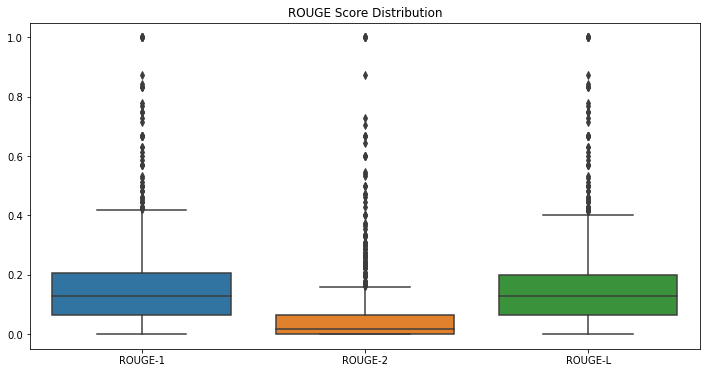

In [17]:
compute_rouge(ref_labels, ppo_pred_texts )

## SFT only 모델의 generation 

In [28]:
# 허깅페이스의 pipleline 클래스를 사용하여 generator 생성
sft_generator = pipeline('text-generation', model='./modles/output_1_SFT', tokenizer=tokenizer)

generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=tokenizer.eos_token_id, #375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)




from tqdm import tqdm

sft_results = []
for input_text in tqdm(inputs, desc="Generating"):
    result = sft_generator(input_text, **generation_args)
    sft_results.append(result)


sft_pred_texts = [
    r[0]["generated_text"].split("### Response(응답):")[-1].strip()
    for r in sft_results
    ]

    
print(len(sft_pred_texts))

print(sft_pred_texts[0])
print()
print(sft_pred_texts[0])

Generating: 100%|██████████| 1000/1000 [50:07<00:00,  3.01s/it] 

1000
저는 인공지능 어시스턴트이기 때문에 서브 스피드의 속도와 관련된 정보를 알 수 없습니다. 죄송합니다.

저는 인공지능 어시스턴트이기 때문에 서브 스피드의 속도와 관련된 정보를 알 수 없습니다. 죄송합니다.


In [29]:
print(type(sft_results))
sft_results[0]

<class 'list'>


[{'generated_text': '### Instruction(명령어):\n최고 서브 스피드 속도가 얼마나 되지\n\n### Response(응답):저는 인공지능 어시스턴트이기 때문에 서브 스피드의 속도와 관련된 정보를 알 수 없습니다. 죄송합니다.'}]

In [30]:
cnt = 0
for prompt, ref, pred in zip(inputs, ref_labels, sft_pred_texts):
    print()
    print("[Prompt]", prompt)
    print("[Ref   ]", ref)
    print("[Gen   ]", pred)
    cnt +=1
    if cnt >= 5 :
        break


[Prompt] ### Instruction(명령어):
최고 서브 스피드 속도가 얼마나 되지

### Response(응답):
[Ref   ] 저는 인공지능 언어모델입니다 . 서브 스피드 라는 용어가 정확히 어떤 것인지 알 수 없어서 답변해드리기 어렵습니다 . 더 자세한 정보를 제공해주시면 답변 드릴 수 있습니다 . 감사합니다 .
[Gen   ] 저는 인공지능 어시스턴트이기 때문에 서브 스피드의 속도와 관련된 정보를 알 수 없습니다. 죄송합니다.

[Prompt] ### Instruction(명령어):
라울이 레알마드리드에서 몇 골 넣었어

### Response(응답):
[Ref   ] 요즘은 레알 마드리드에서 뛰지 않는 라울 곤잘레스의 경우 , 2010 11 시즌 동안 레알 마드리드에서 13골을 넣었다 .
[Gen   ] 저는 라울의 골 수를 알 수 없습니다. 라울은 현재 리버풀 fc에서 뛰고 있으며, 공격수나 수비수 등 다양한 분야에서 활약하고 있습니다.

[Prompt] ### Instruction(명령어):
여기 얼마에요 ?

### Response(응답):
[Ref   ] 저는 가격을 알 수 없습니다 . 제가 할 수 있는 것은 대화나 자연어 이해에 대한 질문에 답변하는 것입니다 . 상황에 따라 가격이 달라질 수 있으므로 , 판매자나 가게 직원에게 직접 가격을 문의해보시는 것이 좋습니다 .
[Gen   ] 죄송합니다, 저는 가격을 알 수 없습니다. 어떤 상품에 대해 문의하시는 건가요?

[Prompt] ### Instruction(명령어):
마리 앙투아네트는 프랑스와의 동맹을 위해 누구와 정략결혼을 했는가 ?

### Response(응답):
[Ref   ] 마리 앙투아네트는 오스트리아의 황자인 프란츠 요셉과 정략결혼을 했습니다 .
[Gen   ] 마리 앙투아네트 는 프랑스와의 동맹을 강화하기 위해 앙리 4세, 마리 앙투아네트와 함께 결혼했습니다.

[Prompt] ### Instruction(명령어):
술이 보약도 아니고

### Response(

📊 평균 ROUGE 점수
ROUGE-1 F1: 0.2017
ROUGE-2 F1: 0.0869
ROUGE-L F1: 0.1994


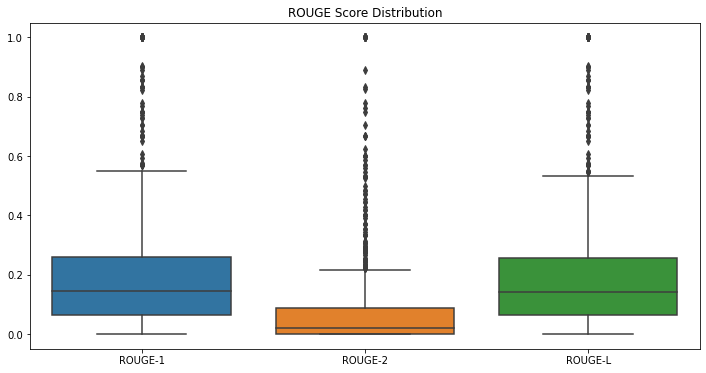

In [31]:
compute_rouge(ref_labels, sft_pred_texts )

# <회고>

## 실험 기록 
1. SFT와 generation 비교를 하려면, SFT 훈련을 하지 않은 test_dataset (마지막 1000건)으로 비교하자!
2. 저장된 PPO pretrained model을 불러와서 generator를 쓰려고 해봤는데..... 
3. 1000건 generate에 약 1시간 소요

4. RM 훈련을 ranking 0-1, 0-2 set로 훈련했는데, ranking 0-1, 0-2, 1-2 set로 다시 훈련해보자
   -> 별 영향 없음 
5. Eearly_stopping 옵션을 주지 않으면 max_length까지 출력해서 쓸데없는 내용들이 많이 붙어 있다 
   -> early_stopping 추가 후, PPO의 rouge값이 조금 개선됨. 


### 루브릭 1.  KoGPT와 SFT 모델  결과를 정량/정성적으로 비교

✅ koChatGPT_SFT 파일 참고

 - KoGTP가 SFT보다 ROUGE 점수는 더 좋게 나왔으나, SFT가 더 자연스러운 문장을 생성한다. 

### 루브릭 2. SFT 모델의 결과와 PPO 모델 결과를 정량/정성적으로 비교
- SFT만 한 모델의 genereate와  SFT+RM 한 PPO 모델의 generate 

✅ ROUGE 점수

| Metric  | PPO F1 Score | SFT F1 Score |
| ------- | ------------ |------------- |
| ROUGE-1 | 0.1626       |  0.2017      |
| ROUGE-2 | 0.0644       |  0.0869      |
| ROUGE-L | 0.1606       |  0.1994      |

✅ Response 생성 능력 
 
- SFT, PPO 둘다 자연스럽고 필요한 문장으로 출력되는데, SFT가 좀 더 필요한 내용으로만 출력된다. 
- PPO는 문장이 반복되는 느낌이 있다. (이는 reward에서 높은 점수를 주는 패턴을 반복학습해서 생기는 현상일 수 있다. ) 


✅ ROUGE 점수가 낮은 이유
 - ROUTE는 단순히 n-gram 중첩률을 보므로, 문장이 그럴듯하게 생성되어도, reference에 있는 단어들과 중첩이 적으면 점수가 낮게 나온다. 
 - ROUGE는 특히 reference에 있는 핵심 키워드가 생성 결과에 엄라나 포함되었는지를 측정한다. 
 - PPO 학습은 사람의 피드백으로 학습된 것이라서, 의미 일치보다는 자연스러움에 더 강하다. 
 
✅ 생각해 볼것 
 - 자연스럼움 + 정확성 필요함. "정확성"을 높이려면 학습 데이타가 더 많아야 할까?


### 루브릭 3. 정량적 성능 향상
1. 기존 데이터셋을 추가로 정제하고, beam-search, top-k sampling등 generation 성능을 올리기 위한 기법을 적용하여 시험해 모델 성능을 향상시켰다. 

✅ 데이터셋 정제 : KoChatGPT_eda 파일 참고 
  - 데이터 정제 및 불필요한 데이터 삭제
  - ranking이 맞지 않는 RM 데이타 존재


